In [1]:
 import math
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 import seaborn as sns
 from scipy.stats import binom,norm,poisson,geom,ttest_1samp,ttest_ind,ttest_rel,chisquare
 from scipy.stats import chi2_contingency,f_oneway
 from statsmodels.graphics.gofplots import qqplot
 from statsmodels.stats import weightstats as stests
 from statsmodels.stats.proportion import proportions_ztest
 !pip install pingouin
 import pingouin as pg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.2 MB/s eta 0:00:00


In [2]:
a = pd.read_csv("yulu_case_study.csv")
a.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
a.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [5]:
a.ndim,a.shape

(2, (10886, 12))

There are 10886 rows and 12 columns in the dataset

Checking for missing values

In [6]:
# Check for missing values
print(a.isnull().sum())
# Example if 'column_name' had missing values:
# a['column_name'].fillna(a['column_name'].mean(), inplace=True) # Impute with mean
# a['column_name'].fillna(a['column_name'].median(), inplace=True) # Impute with median
# a['column_name'].fillna(a['column_name'].mode()[0], inplace=True) # Impute with mode

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64


There are no missing values in the dataset

Identifying duplicate records in the dataset

In [7]:
# Identify duplicate records
duplicate_records = a[a.duplicated()]
print("Number of duplicate records:", duplicate_records.shape[0])
# Remove duplicate records
a_cleaned = a.drop_duplicates()
print("Number of records after removing duplicates:", a_cleaned.shape[0])

Number of duplicate records: 0
Number of records after removing duplicates: 10886


Identifying and Removing Outliners

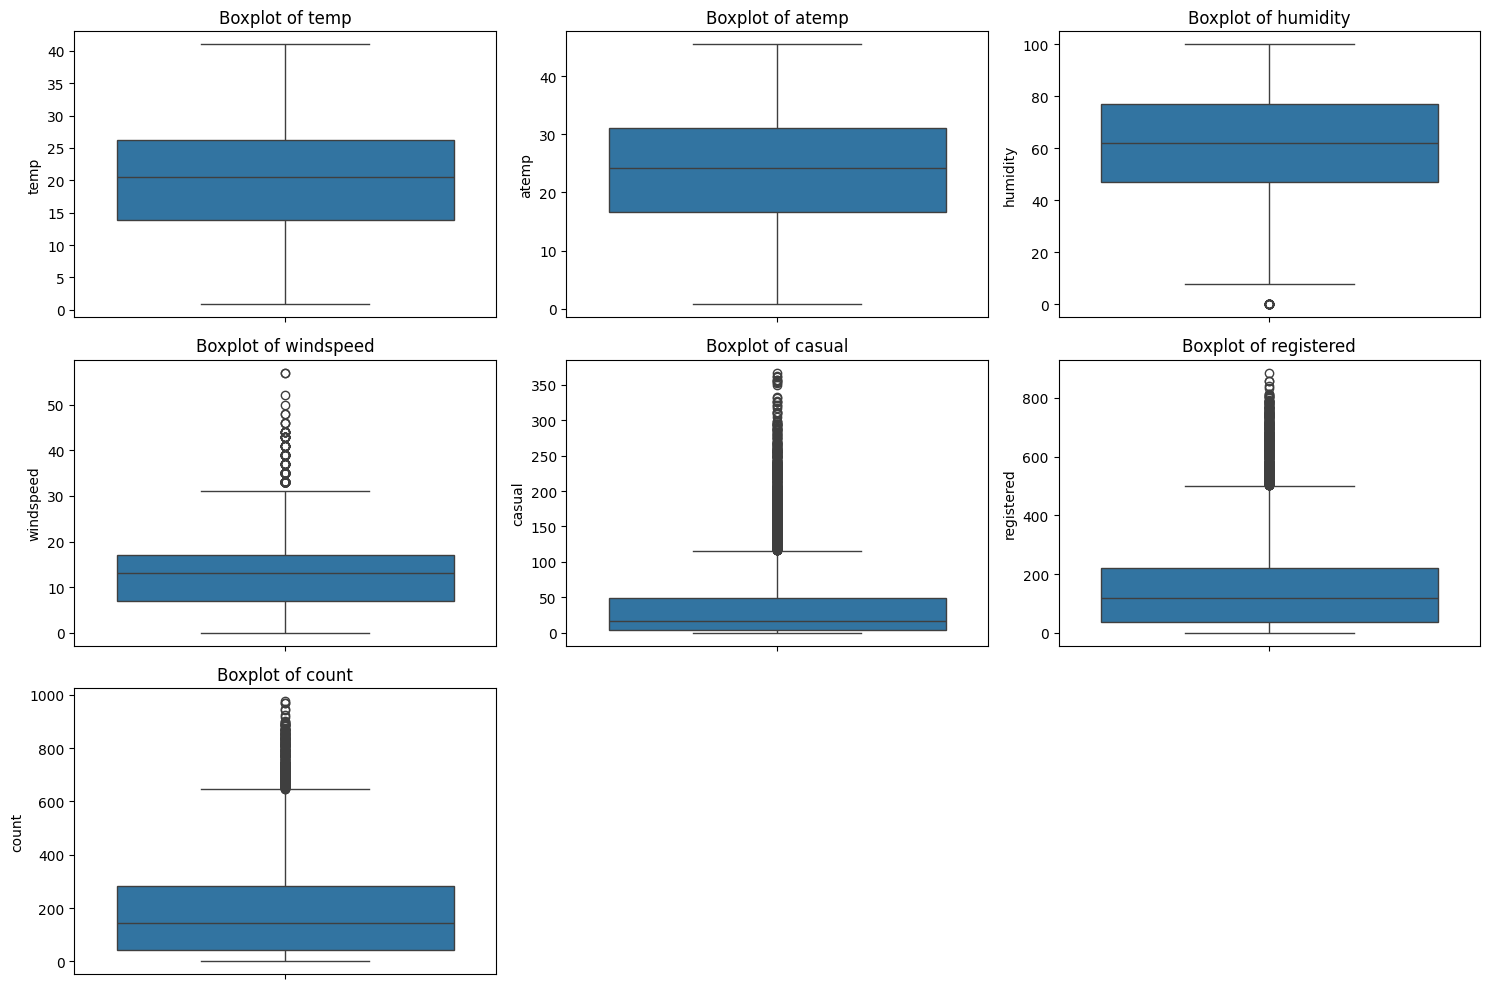

Original number of records: 10886
Number of records after removing outliers: 9383


In [8]:
# Select numerical columns for outlier detection
numerical_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
# Create boxplots to visualize outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=a_cleaned[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
# Function to remove outliers using IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()
    return df_cleaned
# Apply outlier removal to the relevant numerical columns (excluding 'count' as it's the target variable)
columns_to_clean = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered']
a_cleaned_outliers = a_cleaned.copy()
for col in columns_to_clean:
    a_cleaned_outliers = remove_outliers_iqr(a_cleaned_outliers, col)
print(f"Original number of records: {a_cleaned.shape[0]}")
print(f"Number of records after removing outliers: {a_cleaned_outliers.shape[0]}")
# You can now use a_cleaned_outliers for further analysis

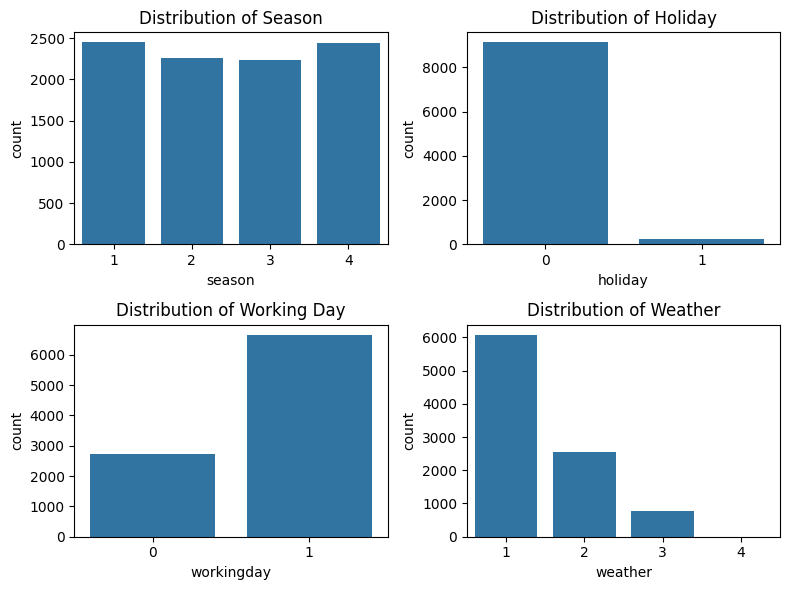

In [15]:
plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
sns.countplot(data=a_cleaned_outliers, x='season')
plt.title('Distribution of Season')
plt.subplot(2, 2, 2)
sns.countplot(data=a_cleaned_outliers, x='holiday')
plt.title('Distribution of Holiday')
plt.subplot(2, 2, 3)
sns.countplot(data=a_cleaned_outliers, x='workingday')
plt.title('Distribution of Working Day')
plt.subplot(2, 2, 4)
sns.countplot(data=a_cleaned_outliers, x='weather')
plt.title('Distribution of Weather')
plt.tight_layout()
plt.show()

From the above visualization,we are able to see the count of various variables specifically weather where in most of the days is clear,fewer clouds and partly cloudy

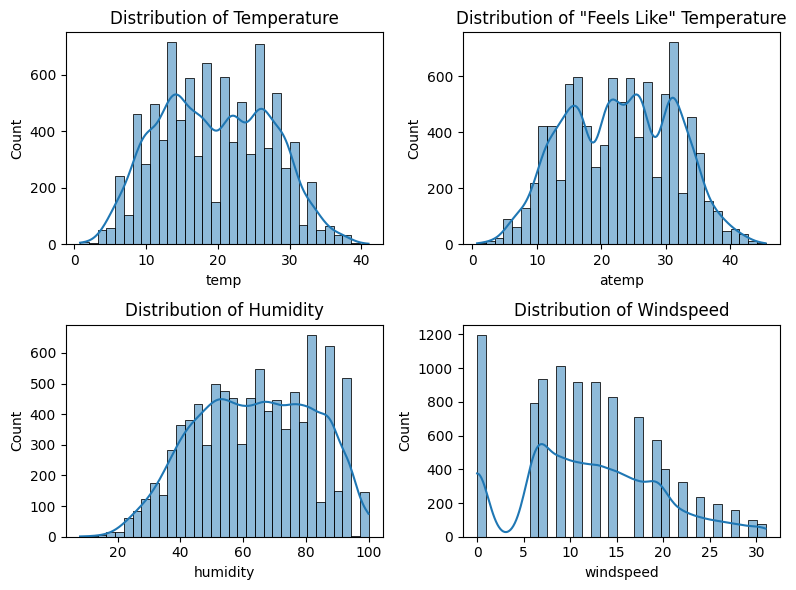

In [16]:
plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
sns.histplot(data=a_cleaned_outliers, x='temp', kde=True)
plt.title('Distribution of Temperature')
plt.subplot(2, 2, 2)
sns.histplot(data=a_cleaned_outliers, x='atemp', kde=True)
plt.title('Distribution of "Feels Like" Temperature')
plt.subplot(2, 2, 3)
sns.histplot(data=a_cleaned_outliers, x='humidity', kde=True)
plt.title('Distribution of Humidity')
plt.subplot(2, 2, 4)
sns.histplot(data=a_cleaned_outliers, x='windspeed', kde=True)
plt.title('Distribution of Windspeed')
plt.tight_layout()
plt.show()

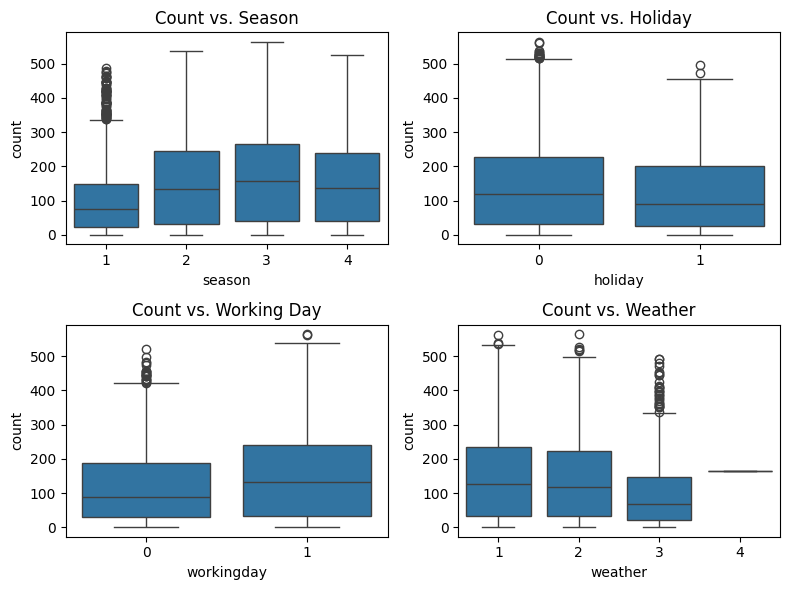

In [17]:
plt.figure(figsize=(8,6))
plt.subplot(2, 2, 1)
sns.boxplot(data=a_cleaned_outliers, x='season', y='count')
plt.title('Count vs. Season')
plt.subplot(2, 2, 2)
sns.boxplot(data=a_cleaned_outliers, x='holiday', y='count')
plt.title('Count vs. Holiday')
plt.subplot(2, 2, 3)
sns.boxplot(data=a_cleaned_outliers, x='workingday', y='count')
plt.title('Count vs. Working Day')
plt.subplot(2, 2, 4)
sns.boxplot(data=a_cleaned_outliers, x='weather', y='count')
plt.title('Count vs. Weather')
plt.tight_layout()
plt.show()

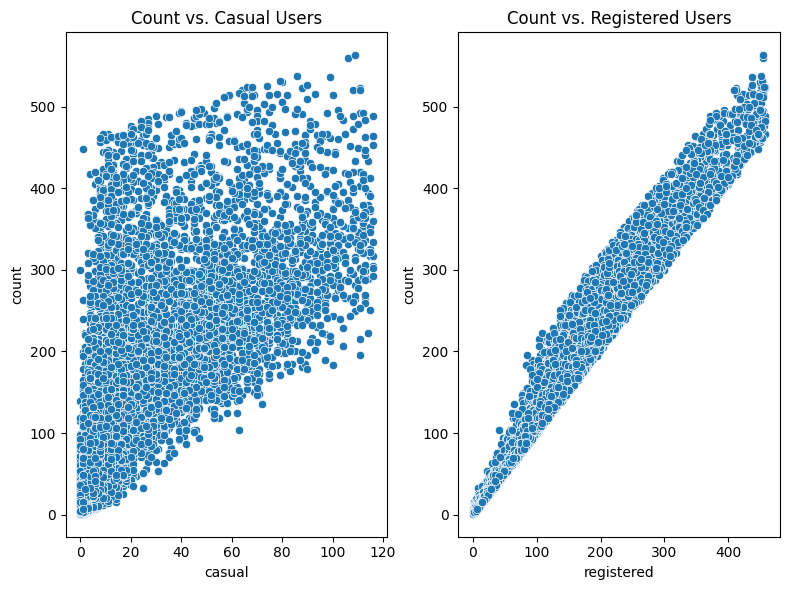

In [45]:
plt.figure(figsize=(8, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(data=a_cleaned_outliers, x='casual', y='count')
plt.title('Count vs. Casual Users')
plt.subplot(1, 2, 2)
sns.scatterplot(data=a_cleaned_outliers, x='registered', y='count')
plt.title('Count vs. Registered Users')
plt.tight_layout()
plt.show()

Calculating and visualizing the correlation matrix of the numerical variables using a heatmap.



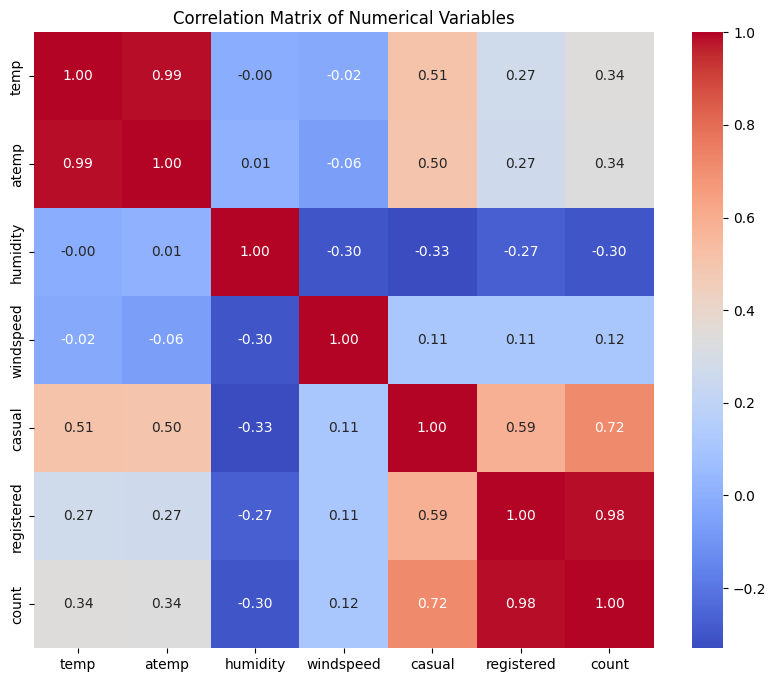

In [14]:
numerical_cols = ['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count']
correlation_matrix = a_cleaned_outliers[numerical_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Variables")
plt.show()

*   The dataset contains more instances of higher humidity levels and lower wind speeds, with a notable peak at zero wind speed.
*   Bike rental counts ('count') appear to vary across different seasons, holidays, working days, and weather conditions, as indicated by the box plots.
*   The number of registered users shows a strong positive linear relationship with the total bike rental count, while casual users also contribute positively to the total count.
*   The correlation heatmap reveals a strong positive correlation between 'temp' and 'atemp', a moderate negative correlation between 'humidity' and 'count', and a strong positive correlation between 'registered' users and 'count'.



**Reasoning**:
Convert the 'datetime' column to datetime objects and extract hour, day of the week, month, and year into new columns.



In [20]:
a_cleaned_outliers['datetime'] = pd.to_datetime(a_cleaned_outliers['datetime'])
a_cleaned_outliers['hour'] = a_cleaned_outliers['datetime'].dt.hour
a_cleaned_outliers['dayofweek'] = a_cleaned_outliers['datetime'].dt.dayofweek
a_cleaned_outliers['month'] = a_cleaned_outliers['datetime'].dt.month
a_cleaned_outliers['year'] = a_cleaned_outliers['datetime'].dt.year
a_cleaned_outliers.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour,dayofweek,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2,5,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3,5,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4,5,1,2011


Performing ANOVA tests for each categorical variable against 'count' and print the p-values.



In [21]:
categorical_cols = ['season', 'holiday', 'workingday', 'weather', 'hour', 'dayofweek', 'month', 'year']
for col in categorical_cols:
    groups = a_cleaned_outliers.groupby(col)['count'].apply(list)
    fvalue, pvalue = f_oneway(*groups)
    print(f'ANOVA test for {col}: F-statistic = {fvalue:.4f}, p-value = {pvalue:.4f}')

ANOVA test for season: F-statistic = 151.1004, p-value = 0.0000
ANOVA test for holiday: F-statistic = 4.4491, p-value = 0.0349
ANOVA test for workingday: F-statistic = 151.2318, p-value = 0.0000
ANOVA test for weather: F-statistic = 37.9644, p-value = 0.0000
ANOVA test for hour: F-statistic = 461.9760, p-value = 0.0000
ANOVA test for dayofweek: F-statistic = 29.0034, p-value = 0.0000
ANOVA test for month: F-statistic = 49.2458, p-value = 0.0000
ANOVA test for year: F-statistic = 276.1668, p-value = 0.0000


From the previous ANOVA tests, all categorical variables had very low p-values (< 0.05),indicating a significant relationship with 'count'.

In [25]:
significant_categorical_vars = ['season', 'holiday', 'workingday', 'weather', 'hour', 'dayofweek', 'month', 'year']
# From the correlation matrix, we observe the following correlations with 'count':
# temp: 0.34
# atemp: 0.34
# humidity: -0.30
# windspeed: 0.12
# casual: 0.72
# registered: 0.98
# Variables with notable correlation coefficients (magnitude generally > 0.3 or significant for the domain)
significant_numerical_vars = ['temp', 'atemp', 'humidity', 'casual', 'registered']
print("Significant variables for predicting bike rental demand:")
print(significant_categorical_vars)
print(significant_numerical_vars)

Significant variables for predicting bike rental demand:
['season', 'holiday', 'workingday', 'weather', 'hour', 'dayofweek', 'month', 'year']
['temp', 'atemp', 'humidity', 'casual', 'registered']



*   All tested categorical variables ('season', 'holiday', 'workingday', 'weather', 'hour', 'dayofweek', 'month', 'year') show a statistically significant relationship with bike rental demand ('count'), as indicated by low p-values from ANOVA tests.
*   Numerical variables 'temp', 'atemp', 'humidity', 'casual', and 'registered' exhibit notable correlation with 'count', with 'casual' (0.72) and 'registered' (0.98) showing particularly strong correlations.



 Checking if there any significant difference between the no. of bike rides on Weekdays and Weekends

 Formulating Null Hypothesis (H0) and Alternate Hypothesis (H1)
H0: There is no significant difference in the average number of bike rides between weekdays and weekends.
H1: There is a significant difference in the average number of bike rides between weekdays and weekends.
2-Sample Independent T-test is appropriate because we are comparing the means of two independent groups (weekdays and weekends).
alpha = 0.05
Separate the data into weekdays and weekends.In this dataset, dayofweek 0-4 are weekdays, and 5-6 are weekends.

In [31]:
alpha = 0.05
weekdays = a_cleaned_outliers[a_cleaned_outliers['dayofweek'].isin([0, 1, 2, 3, 4])]['count']
weekends = a_cleaned_outliers[a_cleaned_outliers['dayofweek'].isin([5, 6])]['count']
# Using pingouin for the t-test
ttest_result = pg.ttest(weekdays, weekends, correction=False)
print(ttest_result)
# e. Decide whether to accept or reject the Null Hypothesis.
p_value = ttest_result['p-val'].iloc[0]
print(f'\nSignificance Level (alpha): {alpha}')
print(f'P-value: {p_value:.4f}')
if p_value <= alpha:
    print("Decision: Reject the Null Hypothesis.")
    print("Conclusion:")
    print("There is a significant difference in the average number of bike rides between weekdays and weekends.")
else:
    print("Decision: Fail to reject the Null Hypothesis.")
    print("Conclusion:")
    print("There is no significant difference in the average number of bike rides between weekdays and weekends.")
print("\nInferences and Recommendations:")
if p_value <= alpha:
    print("The average number of bike rentals is significantly different between weekdays and weekends.")
    print("Based on this finding, Yulu could consider adjusting their operational strategies, such as:")
    print("Increasing the availability of bikes during periods of higher demand")
    print("It may be either weekdays or weekends, depending on which has a higher average.")
    print("-Implementing targeted marketing or pricing strategies based on the day of the week to optimize ridership.")
else:
    print("The average number of bike rentals is not significantly different between weekdays and weekends.")
    print("Based on this finding, Yulu might consider maintaining consistent operational strategies")
    print("This can be done throughout the week, focusing on other factors that influence demand.")

                T   dof alternative         p-val           CI95%   cohen-d  \
T-test  11.885131  9381   two-sided  2.411937e-32  [28.72, 40.06]  0.278463   

             BF10  power  
T-test  6.419e+28    1.0  

Significance Level (alpha): 0.05
P-value: 0.0000
Decision: Reject the Null Hypothesis.
Conclusion:
There is a significant difference in the average number of bike rides between weekdays and weekends.

Inferences and Recommendations:
The average number of bike rentals is significantly different between weekdays and weekends.
Based on this finding, Yulu could consider adjusting their operational strategies, such as:
Increasing the availability of bikes during periods of higher demand
It may be either weekdays or weekends, depending on which has a higher average.
-Implementing targeted marketing or pricing strategies based on the day of the week to optimize ridership.


Conclusion:
There is a significant difference in the average number of bike rides between weekdays and weekends.
Inferences and Recommendations:
The average number of bike rentals is significantly different between weekdays and weekends.
Based on this finding, Yulu could consider adjusting their operational strategies, such as:
Increasing the availability of bikes during periods of higher demand
It may be either weekdays or weekends, depending on which has a higher average.
-Implementing targeted marketing or pricing strategies based on the day of the week to optimize ridership.

 Checking if the demand of bicycles on rent is the same for different Weather conditions

Formulating Null Hypothesis (H0) and Alternate Hypothesis (H1)
H0: The average number of bike rides is the same across all weather conditions.
H1: The average number of bike rides is different for at least one weather condition.
One-way ANOVA test is appropriate because we are comparing the means of a quantitative variable ('count') across three or more independent groups (weather conditions).

Checking Normality Assumption:

Weather Condition 1:


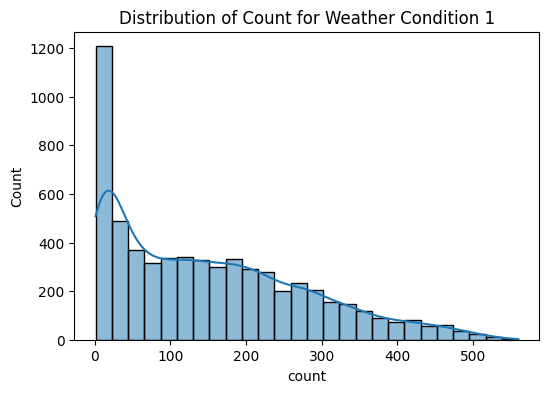

<Figure size 600x400 with 0 Axes>

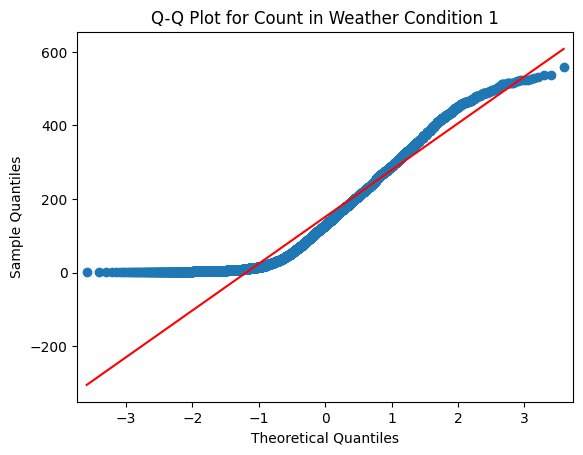

Skewness: 0.7224
Kurtosis: -0.3105
Shapiro-Wilk test: Statistic=0.9209, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).

Weather Condition 2:


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6073.
  res = hypotest_fun_out(*samples, **kwds)


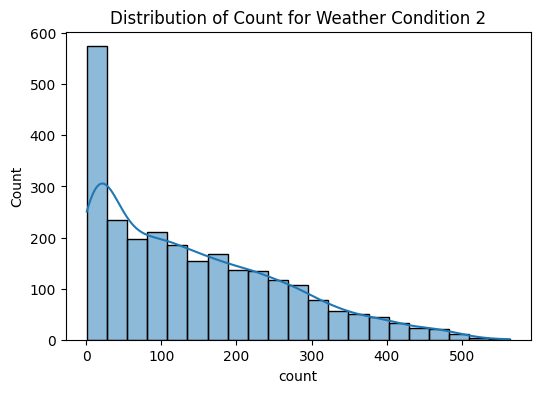

<Figure size 600x400 with 0 Axes>

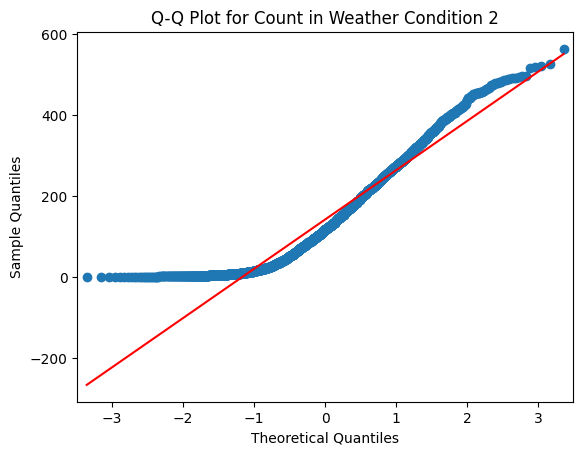

Skewness: 0.8012
Kurtosis: -0.1295
Shapiro-Wilk test: Statistic=0.9161, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).

Weather Condition 3:


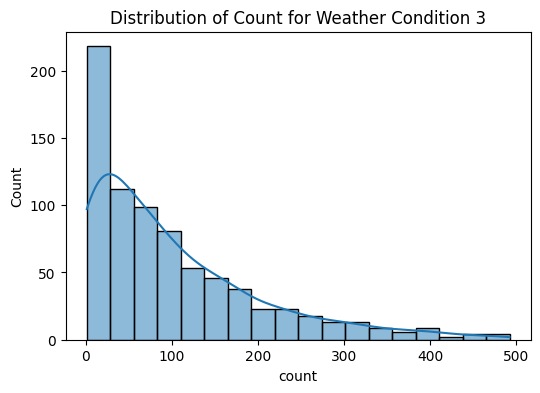

<Figure size 600x400 with 0 Axes>

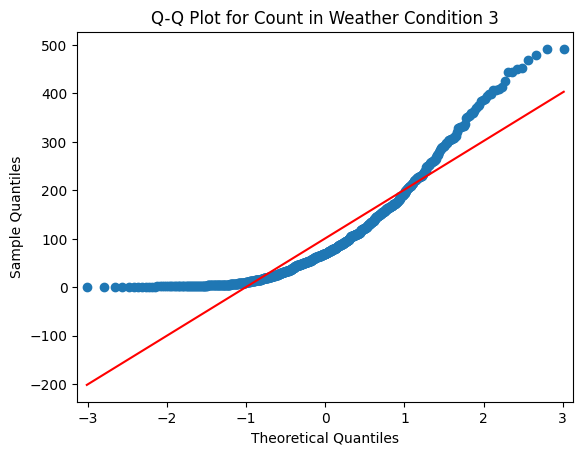

Skewness: 1.4258
Kurtosis: 1.7917
Shapiro-Wilk test: Statistic=0.8507, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).

Weather Condition 4:


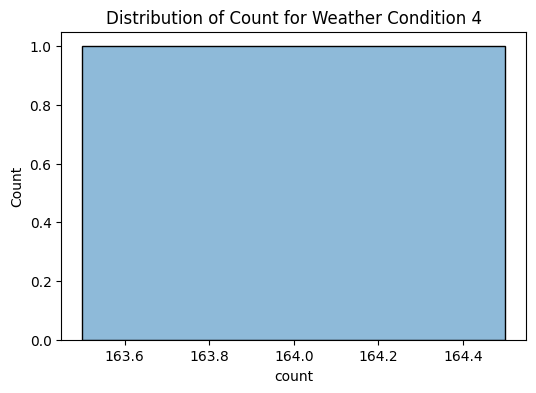

<Figure size 600x400 with 0 Axes>

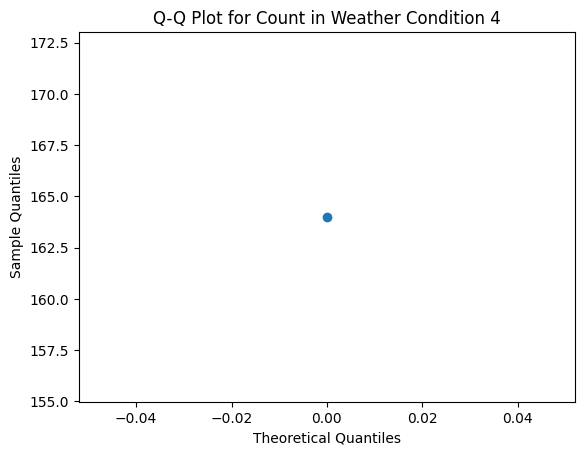

Skewness: nan
Kurtosis: nan
Shapiro-Wilk test: Statistic=nan, p-value=nan
Decision: Fail to reject Null Hypothesis (normal distribution).


/tmp/ipython-input-17320996.py:26: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  shapiro_test = shapiro(subset)


In [48]:
# Import shapiro for normality test
from scipy.stats import shapiro, levene

# i. Normality
print("Checking Normality Assumption:")
for weather_condition in a_cleaned_outliers['weather'].unique():
    subset = a_cleaned_outliers[a_cleaned_outliers['weather'] == weather_condition]['count']
    print(f"\nWeather Condition {weather_condition}:")
    # Histogram in a separate figure
    plt.figure(figsize=(6, 4))
    sns.histplot(subset, kde=True)
    plt.title(f'Distribution of Count for Weather Condition {weather_condition}')
    plt.show()
    # Q-Q Plot in a separate figure
    plt.figure(figsize=(6, 4))
    qqplot(subset, line='s')
    plt.title(f'Q-Q Plot for Count in Weather Condition {weather_condition}')
    plt.show()
    # Skewness and Kurtosis
    print(f"Skewness: {subset.skew():.4f}")
    print(f"Kurtosis: {subset.kurtosis():.4f}")
    # Shapiro-Wilk's test
    shapiro_test = shapiro(subset)
    print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
    if shapiro_test.pvalue < alpha:
        print("Decision: Reject Null Hypothesis (not normal distribution).")
    else:
        print("Decision: Fail to reject Null Hypothesis (normal distribution).")

In [40]:
# ii. Equality Variance
print("\nChecking Equality of Variance Assumption (Levene's test):")
groups = a_cleaned_outliers.groupby('weather')['count'].apply(list)
levene_test = levene(*groups)
print(f"Levene's test: Statistic={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue < alpha:
    print("Decision: Reject Null Hypothesis (variances are not equal).")
else:
    print("Decision: Fail to reject Null Hypothesis (variances are equal).")
# d. Set a significance level and Calculate the test Statistics / p-value.
alpha = 0.05
# Perform One-way ANOVA test
fvalue, pvalue = f_oneway(*groups)
print(f'\nSignificance Level (alpha): {alpha}')
print(f'ANOVA test for Weather: F-statistic = {fvalue:.4f}, p-value = {pvalue:.4f}')
# e. Decide whether to accept or reject the Null Hypothesis.
print("\nDecision based on ANOVA p-value:")
if pvalue <= alpha:
    print("Decision: Reject the Null Hypothesis.")
    print("There is a significant difference in the average number of bike rides between different weather conditions.")
else:
    print("Decision: Fail to reject the Null Hypothesis.")
    print("There is no significant difference in the average number of bike rides between different weather conditions.")
print("\nInferences and Recommendations:")
if pvalue <= alpha:
    print("The weather conditions have a significant impact on the average number of bike rentals.")
    print("Based on this finding, Yulu could consider:")
    print("- Analyzing which specific weather conditions correspond to higher or lower demand")
    print("For example,it can look at the mean 'count' for each weather category.")
    print("- Adjusting bike availability and operational strategies based on predicted weather conditions.")
    print("- Implementing promotions or incentives during unfavorable weather to encourage ridership, if feasible.")
else:
    print("The weather conditions do not have a statistically significant impact on the average number of bike rentals.")
    print("Based on this finding, Yulu might focus on other factors influencing demand when planning operations.")


Checking Equality of Variance Assumption (Levene's test):
Levene's test: Statistic=40.2637, p-value=0.0000
Decision: Reject Null Hypothesis (variances are not equal).

Significance Level (alpha): 0.05
ANOVA test for Weather: F-statistic = 37.9644, p-value = 0.0000

Decision based on ANOVA p-value:
Decision: Reject the Null Hypothesis.
There is a significant difference in the average number of bike rides between different weather conditions.

Inferences and Recommendations:
The weather conditions have a significant impact on the average number of bike rentals.
Based on this finding, Yulu could consider:
- Analyzing which specific weather conditions correspond to higher or lower demand
For example,it can look at the mean 'count' for each weather category.
- Adjusting bike availability and operational strategies based on predicted weather conditions.
- Implementing promotions or incentives during unfavorable weather to encourage ridership, if feasible.


Inferences and Recommendations:
The weather conditions have a significant impact on the average number of bike rentals.
Based on this finding, Yulu could consider:
- Analyzing which specific weather conditions correspond to higher or lower demand
For example,it can look at the mean 'count' for each weather category.
- Adjusting bike availability and operational strategies based on predicted weather conditions.
- Implementing promotions or incentives during unfavorable weather to encourage ridership, if feasible.

 Checking if the demand of bicycles on rent is the same for different Seasons

Formulating Null Hypothesis (H0) and Alternate Hypothesis (H1)
H0: The average number of bike rides is the same across all seasons.
H1: The average number of bike rides is different for at least one season.
One-way ANOVA test is appropriate because we are comparing the means of a quantitative variable ('count') across four independent groups (seasons).

Checking Normality Assumption:

Season Condition 1:


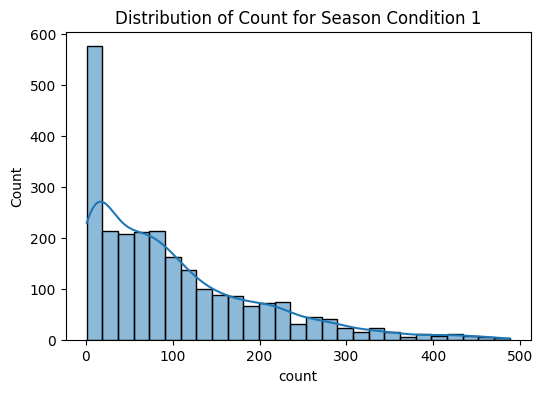

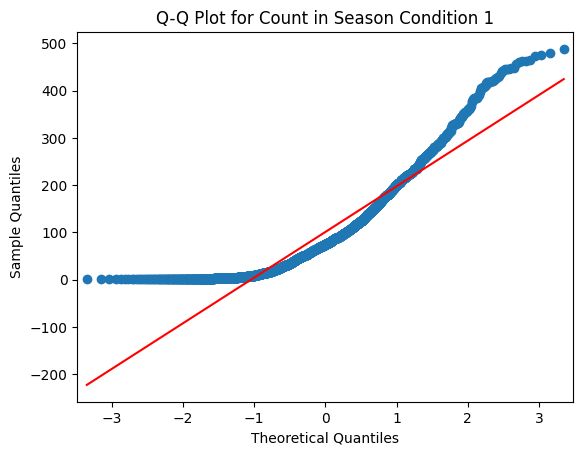

Skewness: 1.2890
Kurtosis: 1.4213
Shapiro-Wilk test: Statistic=0.8714, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).

Season Condition 2:


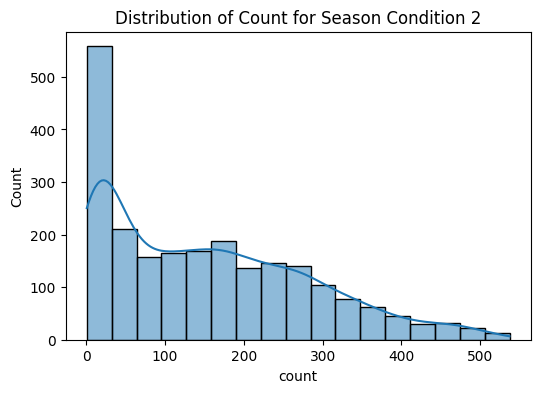

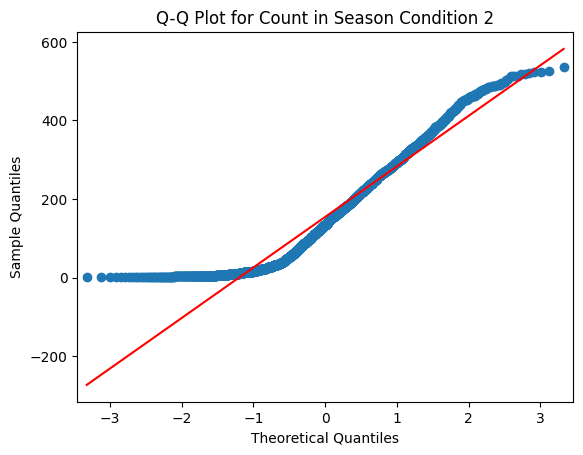

Skewness: 0.6763
Kurtosis: -0.3918
Shapiro-Wilk test: Statistic=0.9226, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).

Season Condition 3:


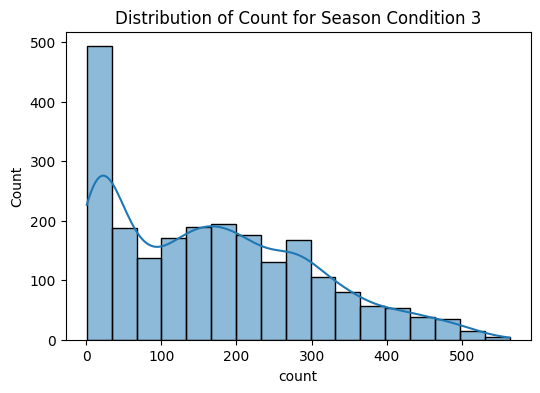

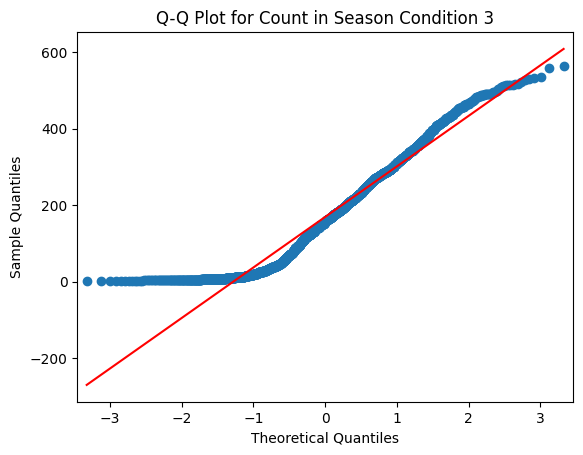

Skewness: 0.5541
Kurtosis: -0.5363
Shapiro-Wilk test: Statistic=0.9370, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).

Season Condition 4:


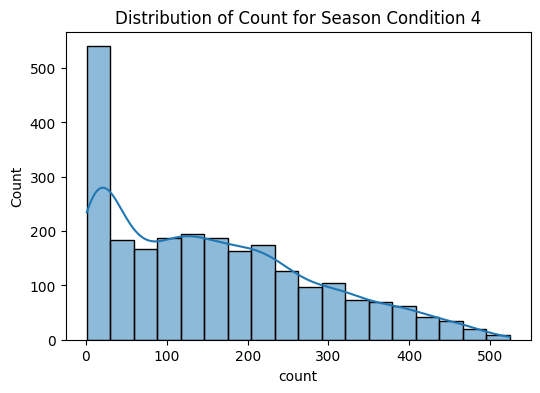

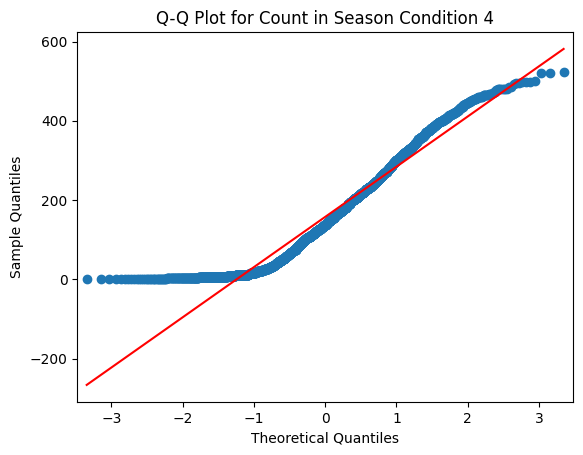

Skewness: 0.6298
Kurtosis: -0.4905
Shapiro-Wilk test: Statistic=0.9303, p-value=0.0000
Decision: Reject Null Hypothesis (not normal distribution).


In [41]:
# Import shapiro for normality test
from scipy.stats import shapiro, levene
# i. Normality
print("Checking Normality Assumption:")
for season_condition in a_cleaned_outliers['season'].unique():
    subset = a_cleaned_outliers[a_cleaned_outliers['season'] == season_condition]['count']
    print(f"\nSeason Condition {season_condition}:")
    # Histogram
    plt.figure(figsize=(6, 4))
    sns.histplot(subset, kde=True)
    plt.title(f'Distribution of Count for Season Condition {season_condition}')
    plt.show()
    # Q-Q Plot
    qqplot(subset, line='s')
    plt.title(f'Q-Q Plot for Count in Season Condition {season_condition}')
    plt.show()
    # Skewness and Kurtosis
    print(f"Skewness: {subset.skew():.4f}")
    print(f"Kurtosis: {subset.kurtosis():.4f}")
    # Shapiro-Wilk's test
    shapiro_test = shapiro(subset)
    print(f"Shapiro-Wilk test: Statistic={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
    if shapiro_test.pvalue < alpha:
        print("Decision: Reject Null Hypothesis (not normal distribution).")
    else:
        print("Decision: Fail to reject Null Hypothesis (normal distribution).")

In [42]:
# ii. Equality Variance
print("\nChecking Equality of Variance Assumption (Levene's test):")
groups = a_cleaned_outliers.groupby('season')['count'].apply(list)
levene_test = levene(*groups)
print(f"Levene's test: Statistic={levene_test.statistic:.4f}, p-value={levene_test.pvalue:.4f}")
if levene_test.pvalue < alpha:
    print("Decision: Reject Null Hypothesis (variances are not equal).")
else:
    print("Decision: Fail to reject Null Hypothesis (variances are equal).")
alpha = 0.05
# Perform One-way ANOVA test
fvalue, pvalue = f_oneway(*groups)
print(f'\nSignificance Level (alpha): {alpha}')
print(f'ANOVA test for Season: F-statistic = {fvalue:.4f}, p-value = {pvalue:.4f}')
# e. Decide whether to accept or reject the Null Hypothesis.
print("\nDecision based on ANOVA p-value:")
if pvalue <= alpha:
    print("Decision: Reject the Null Hypothesis.")
    print("There is a significant difference in the average number of bike rides between different seasons.")
else:
    print("Decision: Fail to reject the Null Hypothesis.")
    print("There is no significant difference in the average number of bike rides between different seasons.")
print("\nInferences and Recommendations:")
if pvalue <= alpha:
    print("Seasons have a significant impact on the average number of bike rentals.")
    print("Based on this finding, Yulu could consider:")
    print("- Analyzing which specific seasons correspond to higher or lower demand")
    print("For example,it can look at the mean 'count' for each season).")
    print("- Adjusting bike availability and operational strategies based on the season.")
    print("- Running season-specific promotions or campaigns.")
else:
    print("Seasons do not have a statistically significant impact on the average number of bike rentals.")
    print("Based on this finding, Yulu might focus on other factors influencing demand when planning operations.")


Checking Equality of Variance Assumption (Levene's test):
Levene's test: Statistic=137.9555, p-value=0.0000
Decision: Reject Null Hypothesis (variances are not equal).

Significance Level (alpha): 0.05
ANOVA test for Season: F-statistic = 151.1004, p-value = 0.0000

Decision based on ANOVA p-value:
Decision: Reject the Null Hypothesis.
There is a significant difference in the average number of bike rides between different seasons.

Inferences and Recommendations:
Seasons have a significant impact on the average number of bike rentals.
Based on this finding, Yulu could consider:
- Analyzing which specific seasons correspond to higher or lower demand
For example,it can look at the mean 'count' for each season).
- Adjusting bike availability and operational strategies based on the season.
- Running season-specific promotions or campaigns.


Inferences and Recommendations:
Seasons have a significant impact on the average number of bike rentals.
Based on this finding, Yulu could consider:
- Analyzing which specific seasons correspond to higher or lower demand
For example,it can look at the mean 'count' for each season).
- Adjusting bike availability and operational strategies based on the season.
- Running season-specific promotions or campaigns.

 Checking if the Weather conditions are significantly different during different Seasons

Formulating Null Hypothesis (H0) and Alternate Hypothesis (H1)
H0: Weather conditions are independent of seasons.
H1: Weather conditions are significantly different during different seasons.
A Chi-square test is appropriate for examining the association between two categorical variables (weather and season).

In [34]:
contingency_table = pd.crosstab(a_cleaned_outliers['weather'], a_cleaned_outliers['season'])
print("Contingency Table (Weather vs. Season):")
display(contingency_table)
alpha = 0.05
# Perform Chi-square test
chi2_statistic, p_value, dof, expected = chi2_contingency(contingency_table)
print(f'\nSignificance Level (alpha): {alpha}')
print(f'Chi-square Statistic: {chi2_statistic:.4f}')
print(f'P-value: {p_value:.4f}')
print(f'Degrees of Freedom: {dof}')
# e. Decide whether to accept or reject the Null Hypothesis.
print("\nDecision based on Chi-square p-value:")
if p_value <= alpha:
    print("Decision: Reject the Null Hypothesis.")
    print("Conclusion: Weather conditions are significantly different during different seasons.")
else:
    print("Decision: Fail to reject the Null Hypothesis.")
    print("Conclusion: Weather conditions are not significantly different during different seasons.")
print("\nInferences and Recommendations:")
if p_value <= alpha:
    print("There is significant association between weather conditions and seasons.")
    print("This means that certain weather conditions are more likely to occur in specific seasons.")
    print("Yulu could use this information to anticipate typical weather patterns in each season")
    print("It can then adjust operations accordingly (e.g., bike availability, maintenance).")
else:
    print("There is no statistically significant association between weather conditions and seasons.")
    print("Yulu might not need to tailor their weather-related strategies specifically based on the season")

Contingency Table (Weather vs. Season):


season,1,2,3,4
weather,,,,
1,1583,1442,1563,1485
2,680,611,503,744
3,184,203,173,211
4,1,0,0,0



Significance Level (alpha): 0.05
Chi-square Statistic: 50.5367
P-value: 0.0000
Degrees of Freedom: 9

Decision based on Chi-square p-value:
Decision: Reject the Null Hypothesis.
Conclusion: Weather conditions are significantly different during different seasons.

Inferences and Recommendations:
There is significant association between weather conditions and seasons.
This means that certain weather conditions are more likely to occur in specific seasons.
Yulu could use this information to anticipate typical weather patterns in each season
It can then adjust operations accordingly (e.g., bike availability, maintenance).


Decision: Reject the Null Hypothesis.
Conclusion: Weather conditions are significantly different during different seasons.
Inferences and Recommendations:
There is significant association between weather conditions and seasons.
This means that certain weather conditions are more likely to occur in specific seasons.
Yulu could use this information to anticipate typical weather patterns in each season
It can then adjust operations accordingly (e.g., bike availability, maintenance).

Observations and Reccomendations :                           •	The dataset contains more instances of higher humidity levels and lower wind speeds, with a notable peak at zero wind speed.
•	Bike rental counts ('count') appear to vary across different seasons, holidays, working days, and weather conditions, as indicated by the box plots.
•	The number of registered users shows a strong positive linear relationship with the total bike rental count, while casual users also contribute positively to the total count.
•	The correlation heatmap reveals a strong positive correlation between 'temp' and 'atemp', a moderate negative correlation between 'humidity' and 'count', and a strong positive correlation between 'registered' users and 'count'.
•	All tested categorical variables ('season', 'holiday', 'workingday', 'weather', 'hour', 'dayofweek', 'month', 'year') show a statistically significant relationship with bike rental demand ('count'), as indicated by low p-values from ANOVA tests.
•	Numerical variables 'temp', 'atemp', 'humidity', 'casual', and 'registered' exhibit notable correlation with 'count', with 'casual' (0.72) and 'registered' (0.98) showing particularly strong correlations.
The average number of bike rentals is significantly different between weekdays and weekends.
Based on this finding, Yulu could consider adjusting their operational strategies, such as: Increasing the availability of bikes during periods of higher demand It may be either weekdays or weekends, depending on which has a higher average. -Implementing targeted marketing or pricing strategies based on the day of the week to optimize ridership
The weather conditions have a significant impact on the average number of bike rentals. Based on this finding, Yulu could consider:
•	Analyzing which specific weather conditions correspond to higher or lower demand For example,it can look at the mean 'count' for each weather category.
•	Adjusting bike availability and operational strategies based on predicted weather conditions.
•	Implementing promotions or incentives during unfavorable weather to encourage ridership, if feasible.
 Seasons have a significant impact on the average number of bike rentals. Based on this finding, Yulu could consider:
•	Analyzing which specific seasons correspond to higher or lower demand For example,it can look at the mean 'count' for each season).
•	Adjusting bike availability and operational strategies based on the season.
•	Running season-specific promotions or campaigns.
There is significant association between weather conditions and seasons. This means that certain weather conditions are more likely to occur in specific seasons.
Yulu could use this information to anticipate typical weather patterns in each season It can then adjust operations accordingly (e.g., bike availability, maintenance).
